# Accentuating Lane Lines

## Importing Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import os

%matplotlib inline

# Make the plotImages function available
%run PlottingHelperFunctions.ipynb

## Testing Color Transforms

Testing Color Transforms...


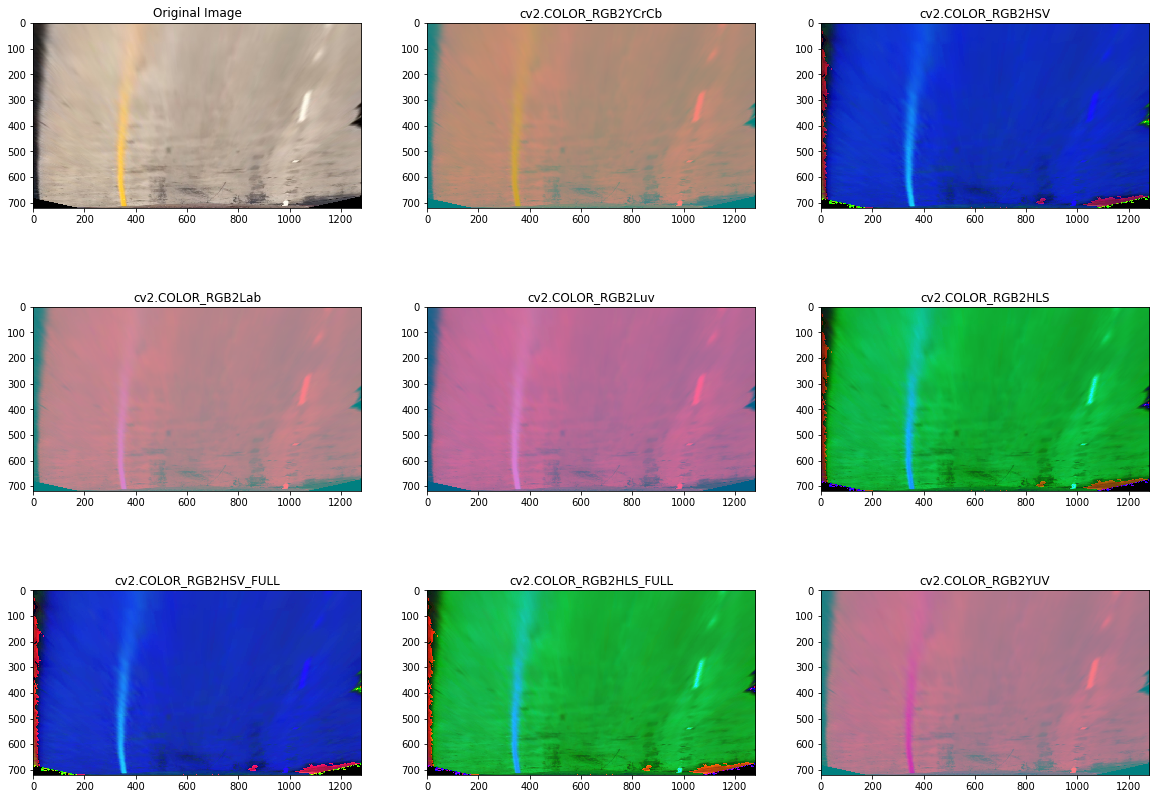

In [2]:
# load in a birds eye view image
birdsEyeViewImage = mpimg.imread("output_images/birdsEyeViewAfterImage.jpg")
# choose several test color conversions
testColorConversions = [birdsEyeViewImage,
                        cv2.cvtColor(birdsEyeViewImage, cv2.COLOR_RGB2YCrCb   ),
                        cv2.cvtColor(birdsEyeViewImage, cv2.COLOR_RGB2HSV     ),
                        cv2.cvtColor(birdsEyeViewImage, cv2.COLOR_RGB2Lab     ),
                        cv2.cvtColor(birdsEyeViewImage, cv2.COLOR_RGB2Luv     ),
                        cv2.cvtColor(birdsEyeViewImage, cv2.COLOR_RGB2HLS     ),
                        cv2.cvtColor(birdsEyeViewImage, cv2.COLOR_RGB2HSV_FULL),
                        cv2.cvtColor(birdsEyeViewImage, cv2.COLOR_RGB2HLS_FULL),
                        cv2.cvtColor(birdsEyeViewImage, cv2.COLOR_RGB2YUV     )]
# list the color conversion names in the same order
testColorConversionNames= ["Original Image",
                        "cv2.COLOR_RGB2YCrCb"   ,            
                        "cv2.COLOR_RGB2HSV"     ,    
                        "cv2.COLOR_RGB2Lab"     ,    
                        "cv2.COLOR_RGB2Luv"     ,    
                        "cv2.COLOR_RGB2HLS"     ,  
                        "cv2.COLOR_RGB2HSV_FULL",       
                        "cv2.COLOR_RGB2HLS_FULL",       
                        "cv2.COLOR_RGB2YUV"     ]

# save the one that looked the most promising
mpimg.imsave("output_images/bestColorTransform.jpg", cv2.cvtColor(birdsEyeViewImage, cv2.COLOR_RGB2HLS_FULL))

print("Testing Color Transforms...")
plotImages(testColorConversions, testColorConversionNames, 3, figsize=(20, 20))

## Applying Sobel Gradient

In [6]:
def sobelGradientBinary(img, thresh=(70, 100), channel=1):
    # Expects HLS image and uses the L channel by default
    # Take the derivative in the x direction
    sobelX = cv2.Sobel(img[:,:,channel], cv2.CV_64F, 1, 0)

    # Absolute x derivative to accentuate lines away from horizontal
    absoluteSobelX = np.absolute(sobelX) 
    # Scale the absolute sobel based on its maximum value and
    # transform it to a uint8 between 0 and 255
    scaledSobel = np.uint8(255 * (absoluteSobelX / np.max(absoluteSobelX)) )
    
    # Create a binary of the same shape
    sobelXBinary = np.zeros_like(scaledSobel)
    # Threshold x gradient based on passed in thresholds    
    sobelXBinary[(scaledSobel >= thresh[0]) & (scaledSobel <= thresh[1])] = 1

    return sobelXBinary

## Testing Sobel Gradient

Testing Sobel X Gradient Thresholds...
Testing Gradient Thresh:  (35, 160)
Testing Gradient Thresh:  (20, 160)
Testing Gradient Thresh:  (15, 160)
Testing Gradient Thresh:  (10, 160)
Testing Gradient Thresh:  (5, 160)


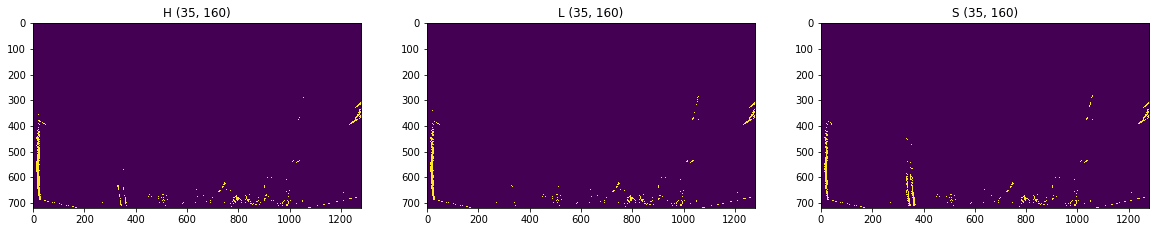

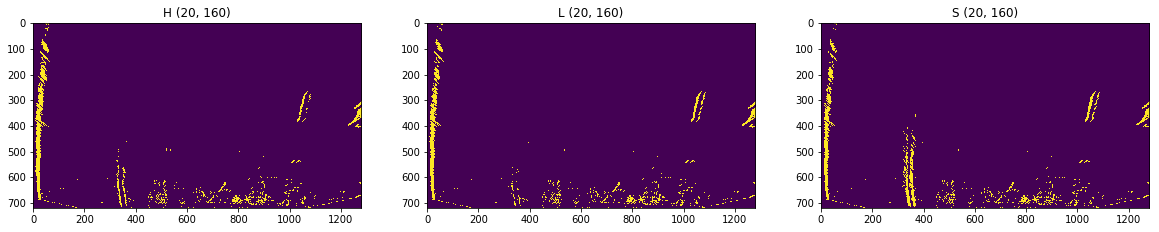

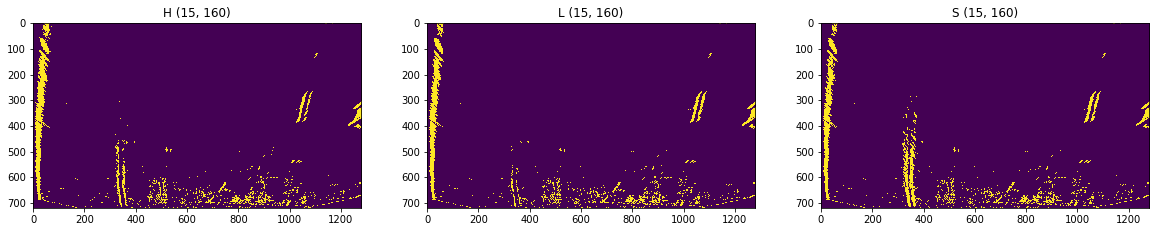

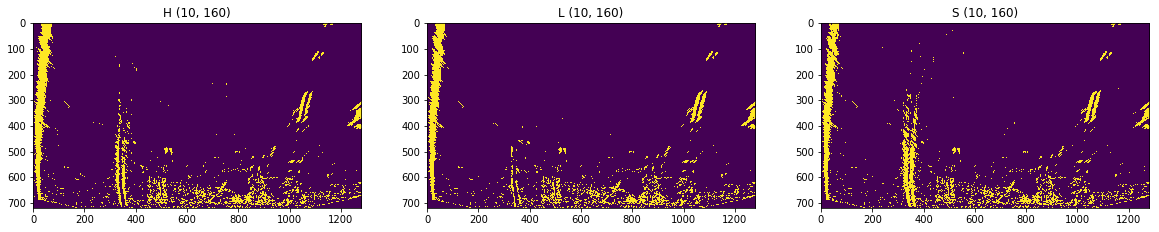

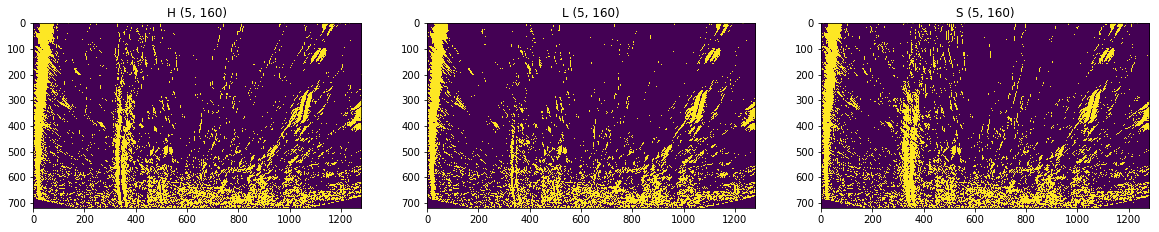

In [32]:
# load in a birds eye view image
birdsEyeViewImage = mpimg.imread("output_images/birdsEyeViewAfterImage.jpg")

# pick several different x thresholds to try
threshesToTry = [(35, 170),
                 (20, 170),
                 (15, 170),
                 (10, 170),
                 (5,  170)]

# loop through each and display the output
print("Testing Sobel X Gradient Thresholds...")
for thresh in threshesToTry:
    print("Testing Gradient Thresh: ", thresh)
    threshStr = "(" + str(thresh[0]) + ", " + str(thresh[1]) + ")"
    # test on all three channels
    plotImages([sobelGradientBinary(birdsEyeViewImage, thresh, channel) for channel in [0, 1, 2]], 
               ["H " + threshStr, "L " + threshStr, "S " + threshStr], 3)
    
# save the one that looked the most promising
mpimg.imsave("output_images/bestSobelGradient.jpg", sobelGradientBinary(birdsEyeViewImage, thresh=(10, 170), channel=1))

## Applying White and Yellow Accentuation

In [7]:
def whiteAndYellow(img):
    # convert to hls
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS_FULL)
    # white mask
    whiteMask = cv2.inRange(hls, (0, 100, 255), (255, 255, 255))
    # yellow mask
    yellowMask = cv2.inRange(hls, (10, 0, 100), (40, 255, 255))
    # combine white and yellow masks
    mask = cv2.bitwise_or(whiteMask, yellowMask)
    return cv2.bitwise_and(img, img, mask=mask)

def whiteAndYellowBinary(img, channel=1):
    return whiteAndYellow(img)[:,:,channel]

## Testing White and Yellow Accentuation

Testing HLS White and Yellow Mask...


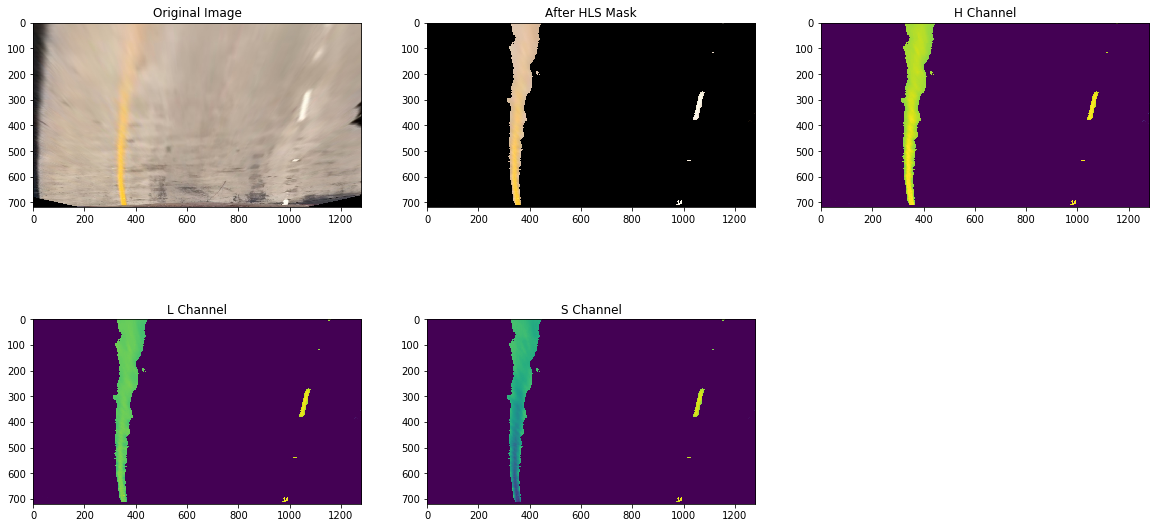

In [8]:
# load in a birds eye view image
birdsEyeViewImage = mpimg.imread("output_images/birdsEyeViewAfterImage.jpg")

# process image with white and yellow filter
ywImg =  whiteAndYellow(birdsEyeViewImage)
ywH = ywImg[:,:,0] 
ywL = ywImg[:,:,1] 
ywS = ywImg[:,:,2] 

# visualize the image in all 3 channels
print("Testing HLS White and Yellow Mask...")
plotImages([birdsEyeViewImage, ywImg, ywH, ywL, ywS], 
           ["Original Image", "After HLS Mask", "H Channel", "L Channel", "S Channel"], 
           3)

# save image for writeup
mpimg.imsave("output_images/whiteAndYellowImage.jpg", ywImg)

## Combining Color Transform, Gradient, and W&Y Accentuation

In [9]:
def accentuateLaneLines(img, debug=False):
    sobelGradientBinaryImage = sobelGradientBinary(img, (20, 170), 1)
    whiteAndYellowBinaryImage = whiteAndYellowBinary(img)
    
    # TODO: combine these images together for the final result
    combinedBinary = np.zeros_like(whiteAndYellowBinaryImage)
    combinedBinary[(sobelGradientBinaryImage == 1) | (whiteAndYellowBinaryImage > 0)] = 1
    
    if debug:
        plotImages([img, sobelGradientBinaryImage, 
                    whiteAndYellowBinaryImage, combinedBinary],
                   ["Birds Eye View Image", "Sobel X Gradient Image", 
                    "White & Yellow Filtered Image", "Combined Result"],
                   4)
    
    return combinedBinary

## Testing Accentuation Function

Testing Sobel and HLS Color Filtering Combination...


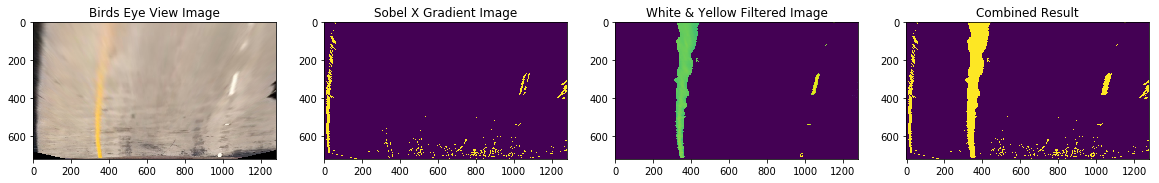

In [10]:
# load in a birds eye view image
birdsEyeViewImage = mpimg.imread("output_images/birdsEyeViewAfterImage.jpg")

# apply accentuation functions to the image
print("Testing Sobel and HLS Color Filtering Combination...")
accentuatedImage = accentuateLaneLines(birdsEyeViewImage, True)

# save image for writeup
mpimg.imsave("output_images/accentuatedLaneLines.jpg", accentuatedImage)